## **Setup Environment**

In [1]:
!pip install tensorflow opencv-python matplotlib scikit-learn tqdm


## Mount Google Drive & Check **Dataset**

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

DATASET_PATH = "/content/drive/MyDrive/Garbage Dataset/images"

# Show class folders and counts
for folder in os.listdir(DATASET_PATH):
    path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(path):
        print(f"{folder:15s} → {len(os.listdir(path))} images")


Mounted at /content/drive
trash           → 2500 images
plastic         → 2288 images
paper           → 2315 images
metal           → 2084 images
glass           → 2500 images
cardboard       → 2214 images


### Histogram Equalization (Preprocessing)

In [3]:
import cv2
from tqdm import tqdm

OUTPUT_DIR = "/content/equalized_dataset"
os.makedirs(OUTPUT_DIR, exist_ok=True)
TARGET_SIZE = (224, 224)

def equalize_color_image(img_bgr):
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

for cls in os.listdir(DATASET_PATH):
    in_dir = os.path.join(DATASET_PATH, cls)
    out_dir = os.path.join(OUTPUT_DIR, cls)
    os.makedirs(out_dir, exist_ok=True)
    for fname in tqdm(os.listdir(in_dir), desc=cls):
        if fname.lower().endswith(('.jpg','.jpeg','.png')):
            img = cv2.imread(os.path.join(in_dir, fname))
            if img is None: continue
            img = cv2.resize(img, TARGET_SIZE)
            img_eq = equalize_color_image(img)
            cv2.imwrite(os.path.join(out_dir, fname), img_eq)

print("✅ Histogram Equalization done — images saved to", OUTPUT_DIR)


cardboard: 100%|██████████| 2214/2214 [01:24<00:00, 26.08it/s] 

✅ Histogram Equalization done — images saved to /content/equalized_dataset


**Load Dataset & Normalize**

In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names *before* applying dataset transformations
num_classes = len(train_ds.class_names)
print("Classes:", train_ds.class_names)


# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 13901 files belonging to 6 classes.
Using 11121 files for training.
Found 13901 files belonging to 6 classes.
Using 2780 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### **Build CNN Model**

In [5]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### **Train Model**

In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1360s 4s/step - accuracy: 0.3159 - loss: 1.8036 - val_accuracy: 0.5169 - val_loss: 1.3345
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1427s 4s/step - accuracy: 0.5145 - loss: 1.3051 - val_accuracy: 0.5867 - val_loss: 1.1502
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1326s 4s/step - accuracy: 0.6181 - loss: 1.0531 - val_accuracy: 0.6313 - val_loss: 1.0453
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1323s 4s/step - accuracy: 0.7046 - loss: 0.8454 - val_accuracy: 0.6680 - val_loss: 0.9946
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1383s 4s/step - accuracy: 0.7710 - loss: 0.6414 - val_accuracy: 0.6856 - val_loss: 0.9992
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1336s 4s/step - accuracy: 0.8070 - loss: 0.5189 - val_accuracy: 0.7011 - val_loss: 1.0498
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1394s 4s/step - accuracy: 0.8679 - loss: 0.3737 - val_accuracy: 0.7079 - val_loss: 1.0778
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1331s 4s/step - accuracy: 0.8914 - loss: 0.3204 - 

## Save Trained Model

In [8]:
model.save("/content/garbage_model_final.h5")
print("✅ Model saved at /content/garbage_model_final.h5")


✅ Model saved at /content/garbage_model_final.h5


# **Download**

In [9]:
from google.colab import files
files.download("/content/garbage_model_final.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Evaluate on Validation Set**

In [10]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


87/87 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7186 - loss: 1.2867
Validation Accuracy: 71.73%


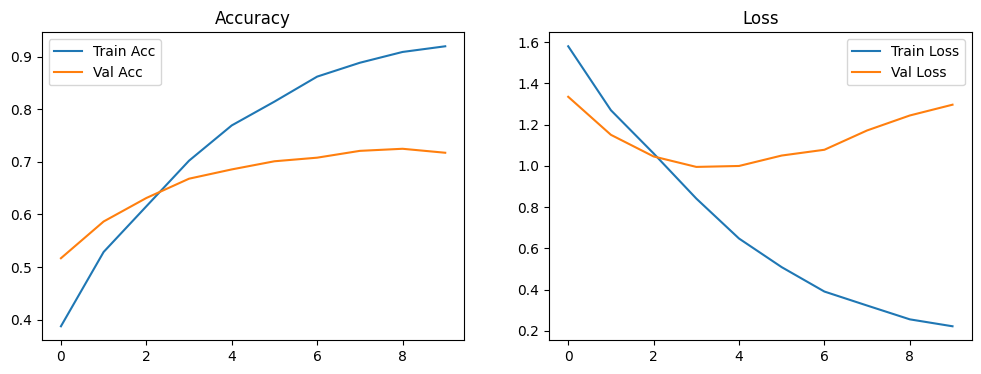

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()


In [14]:
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
print("✅ Classes loaded:", class_names)


✅ Classes loaded: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [25]:
uploaded = files.upload()

for filename in uploaded.keys():
    print("✅ Test image uploaded:", filename)


Saving glass_05474.jpg to glass_05474.jpg
✅ Test image uploaded: glass_05474.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


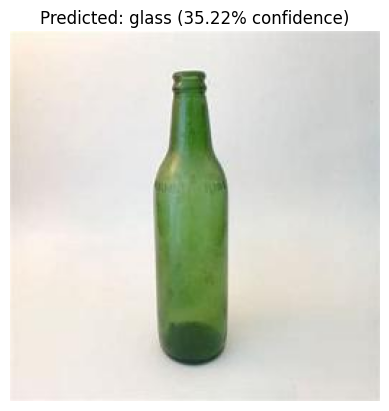

🔍 This image is predicted as **GLASS** with 35.22% confidence.


In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

IMG_SIZE = (224, 224)  # same size used for training

for filename in uploaded.keys():
    # Load and prepare image
    img = Image.open(filename).convert('RGB')
    img_resized = img.resize(IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

    # Predict
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # Get top prediction
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}% confidence)")
    plt.show()

    print(f"🔍 This image is predicted as **{predicted_class.upper()}** with {confidence:.2f}% confidence.")
